In [1]:
# Pipeline Analysis 8 um bin data with Scanpy  
# Author: github.com/acerch

# Following notebooks https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
# and https://nbviewer.org/github/Teichlab/bin2cell/blob/main/notebooks/N2_demo_analysis_crc_public.ipynb 

# Data used available in 10X Genomics Data Base: 
# https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-human-breast-cancer-fresh-frozen

In [2]:
# Import necessary libraries 
import scanpy as sc
import os
import bin2cell as b2c
import celltypist
from celltypist import models
import numpy as np
from matplotlib import rcParams
from matplotlib import font_manager
import matplotlib.pyplot as plt
import squidpy as sq
import seaborn as sns
import pandas as pd

from gprofiler import GProfiler

import time
import psutil

rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')
sc.logging.print_versions()

celltypist	1.6.3
gprofiler-official	1.0.0
psutil	7.0.0
----	----
numba	0.61.2
jaraco.collections	5.1.0
jaraco.text	3.12.1
networkx	3.4.2
texttable	1.7.0
pyct	0.5.0
six	1.17.0
pywin32	310
tifffile	2025.3.30
opencv-python	4.11.0.86 (4.11.0)
jedi	0.19.2
prompt_toolkit	3.0.51
tornado	6.4.2
validators	0.35.0
certifi	2025.1.31 (2025.01.31)
igraph	0.11.8
llvmlite	0.44.0
PySocks	1.7.1
xarray	2024.11.0
ipython	8.35.0
leidenalg	0.10.2
h5py	3.12.1
shapely	2.1.1
wcwidth	0.2.13
cycler	0.12.1
mkl-service	2.4.0
dask	2024.11.2
zipp	3.22.0
imageio	2.37.0
importlib_metadata	8.7.0
multipledispatch	1.0.0 (0.6.0)
requests	2.32.3
joblib	1.4.2
statsmodels	0.14.4
zarr	2.18.3
docrep	0.3.2
pillow	11.2.1
toolz	1.0.0
natsort	8.4.0
geopandas	1.1.0
pycparser	2.21
cffi	1.17.1
stardist	0.9.1
csbdeep	0.8.1
pyarrow	19.0.1
dask-image	2024.5.3
tqdm	4.67.1
stack-data	0.6.3
kiwisolver	1.4.8
debugpy	1.8.14
pytz	2025.2
matplotlib-inline	0.1.7
patsy	1.0.1
asttokens	3.0.0
decorator	5.2.1
jaraco.context	5.3.0
protobuf	3.20.3
numcodecs	0.13.1
charset-normalizer	3.3.2
python-dateutil	2.9.0.post0
lazy_loader	0.4
MarkupSafe	3.0.2
ome-zarr	0.11.1
parso	0.8.4
PyYAML	6.0.2
jaraco.functools	4.0.1
executing	2.2.0
defusedxml	0.7.1
Brotli	1.0.9
xarray-schema	0.0.3
xarray-spatial	0.4.0
pyproj	3.7.1
google-auth	2.38.0
pure_eval	0.2.3
asciitree	0.3.3
setuptools	75.8.0
----	----
Python	3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
OS	Windows-10-10.0.26100-SP0
CPU	32 logical CPU cores, AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
GPU	No GPU found
Updated	2025-07-03 10:05

In [3]:
# Initial time
start_time = time.time()

# Initial memory
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / 1e6 # in MB 

In [4]:
# Establish paths to 8 um data 
datapath = "../../Data/Raw/raw_data_fresh_frozen/"
path008 =  datapath + "binned_outputs/square_008um"
source_image_path = datapath + "Visium_HD_Human_Breast_Cancer_Fresh_Frozen_tissue_image.tif"

In [5]:
# Load 8um default object
bdata = b2c.read_visium(path008, source_image_path = source_image_path)
bdata.var_names_make_unique()
bdata

AnnData object with n_obs × n_vars = 472859 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
# Calculate the standards QC metrics with scanpy.pp.calculate_qc_metrics() 
# and the percentage of mitochondrial read counts per sample
bdata.var["mt"] = bdata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(bdata, qc_vars=["mt"], inplace=True)
bdata

AnnData object with n_obs × n_vars = 472859 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
print("The number of MT genes identified in the data are:", sum(bdata.var["mt"]))

The number of MT genes identified in the data are: 11


<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

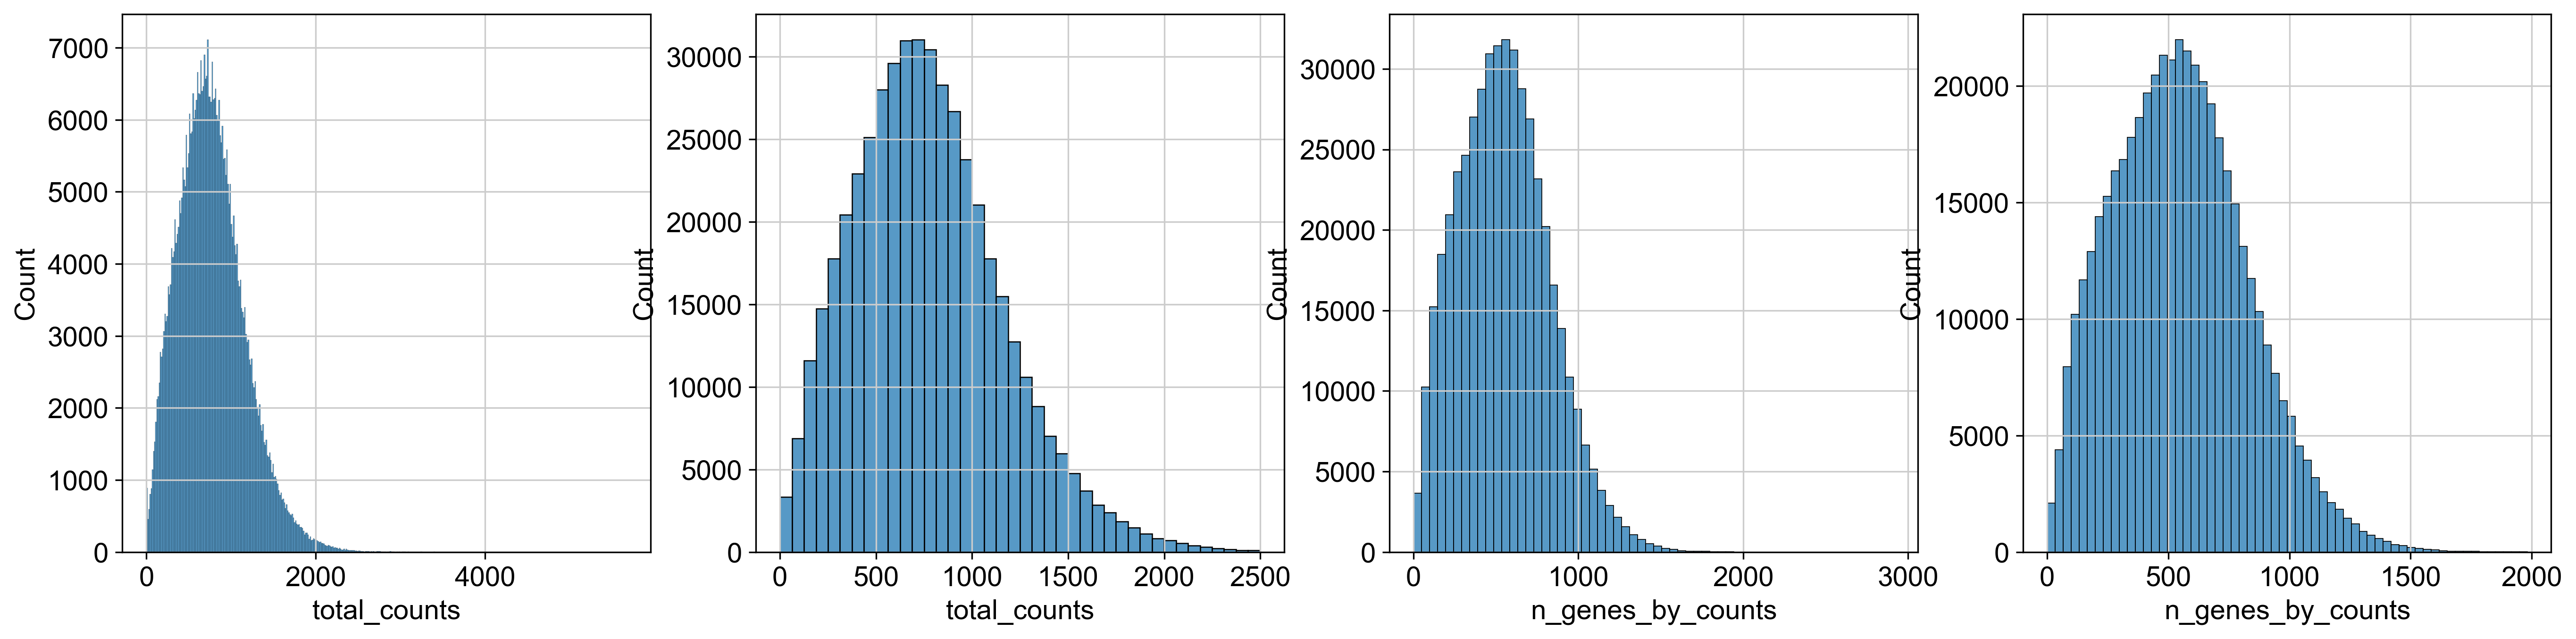

In [8]:
# QC and preprocessing 
# Visiualization Plots for QC 
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
sns.histplot(bdata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    bdata.obs["total_counts"][bdata.obs["total_counts"] < 2500],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(bdata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    bdata.obs["n_genes_by_counts"][bdata.obs["n_genes_by_counts"] < 2000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [9]:
# Filtering of the data 
sc.pp.filter_cells(bdata, min_counts=81)
sc.pp.filter_cells(bdata, min_genes=81)
bdata = bdata[bdata.obs["pct_counts_mt"] < 30].copy()
sc.pp.filter_genes(bdata, min_cells=5)
print(f"Bins after filter: {bdata.n_obs}")
print(f"Genes after filter: {bdata.n_vars}")
bdata

Bins after filter: 463329
Genes after filter: 16375


AnnData object with n_obs × n_vars = 463329 × 16375
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

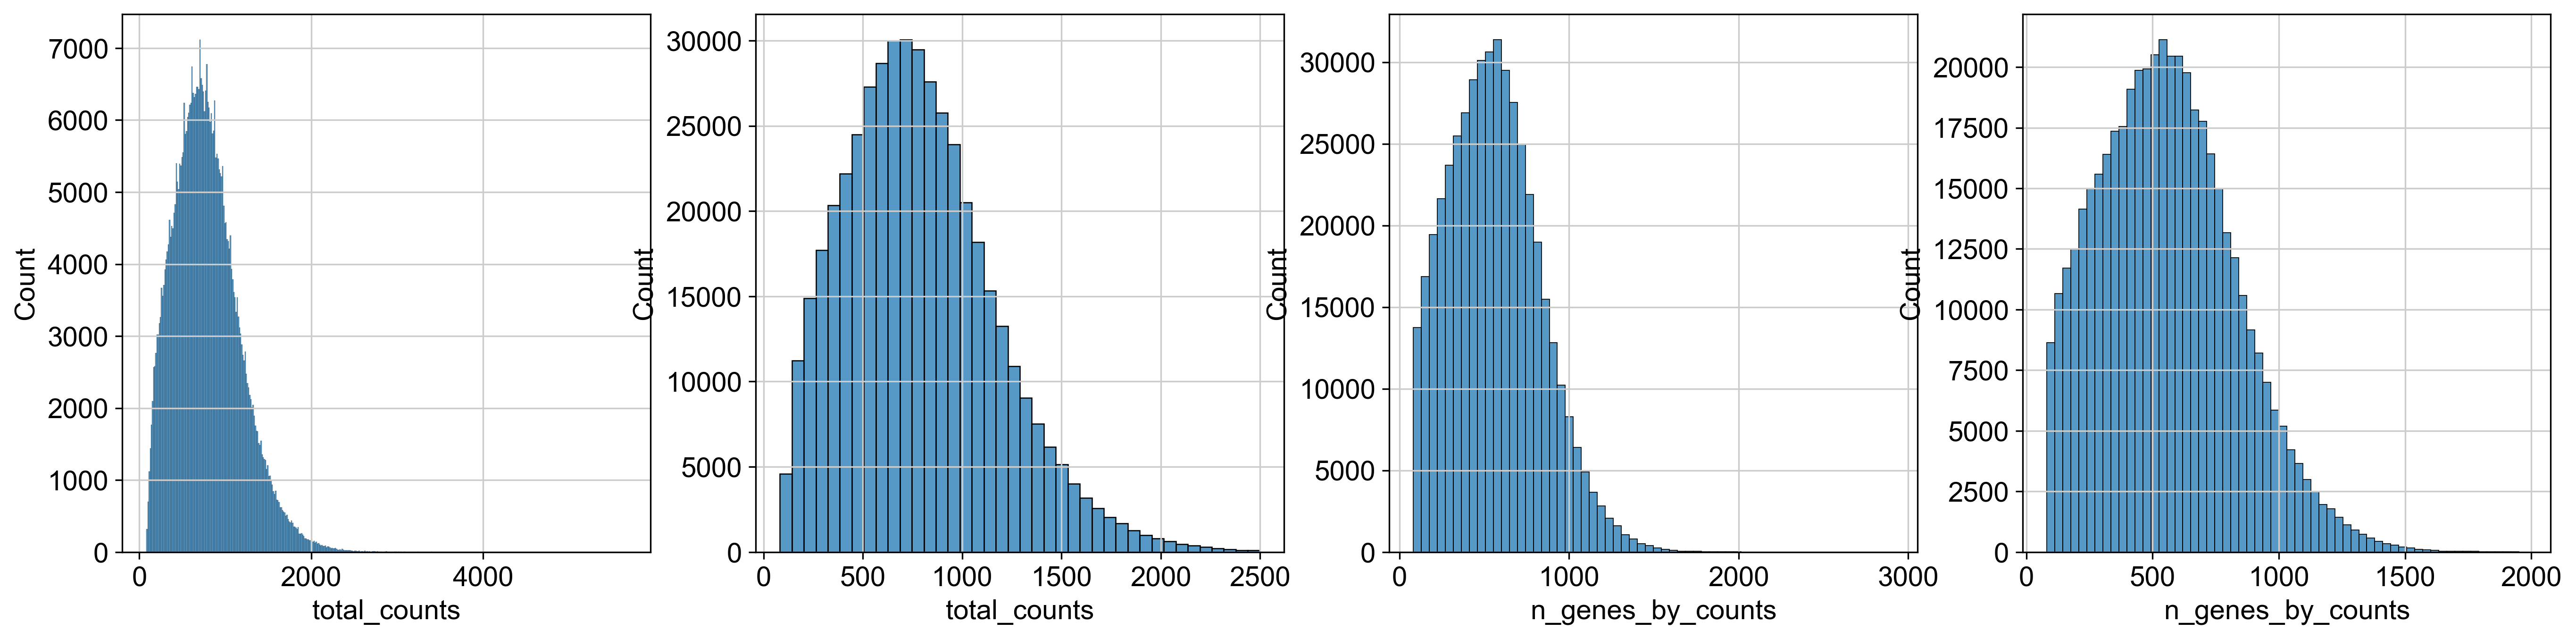

In [10]:
# Plots after filtering 
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
sns.histplot(bdata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    bdata.obs["total_counts"][bdata.obs["total_counts"] < 2500],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(bdata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    bdata.obs["n_genes_by_counts"][bdata.obs["n_genes_by_counts"] < 2000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [11]:
# Calculate mean UMIs/bin and genes/bin 
print('The mean UMIs/bin is:', bdata.obs['total_counts'].mean())
print('The median UMIs/bin is:', np.median(bdata.obs['total_counts']))
print('The mean genes/bin is:', bdata.obs['n_genes_by_counts'].mean())
print('The median genes/bin is:', np.median(bdata.obs['n_genes_by_counts']))

The mean UMIs/bin is: 786.9693
The median UMIs/bin is: 747.0
The mean genes/bin is: 560.5244286457355
The median genes/bin is: 544.0


... storing 'feature_types' as categorical
... storing 'genome' as categorical


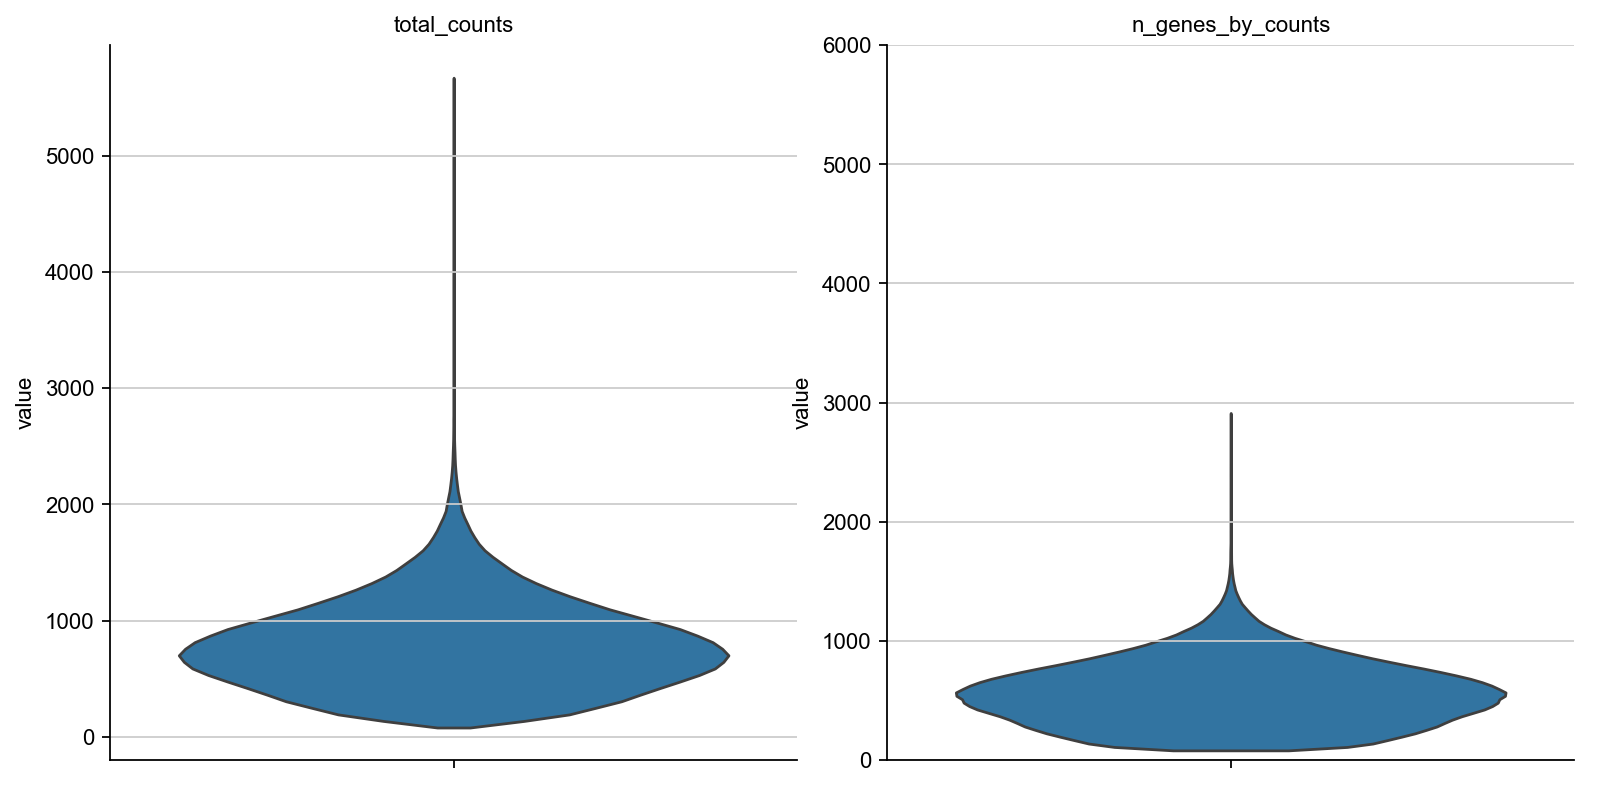

In [12]:
# Violin Plot to visualise data
sc.set_figure_params(dpi=80,fontsize=10,)
sc.pl.violin(bdata, ['total_counts', 'n_genes_by_counts'], size =0, multi_panel=True, show=False)
plt.ylim(0,6000)
plt.show()

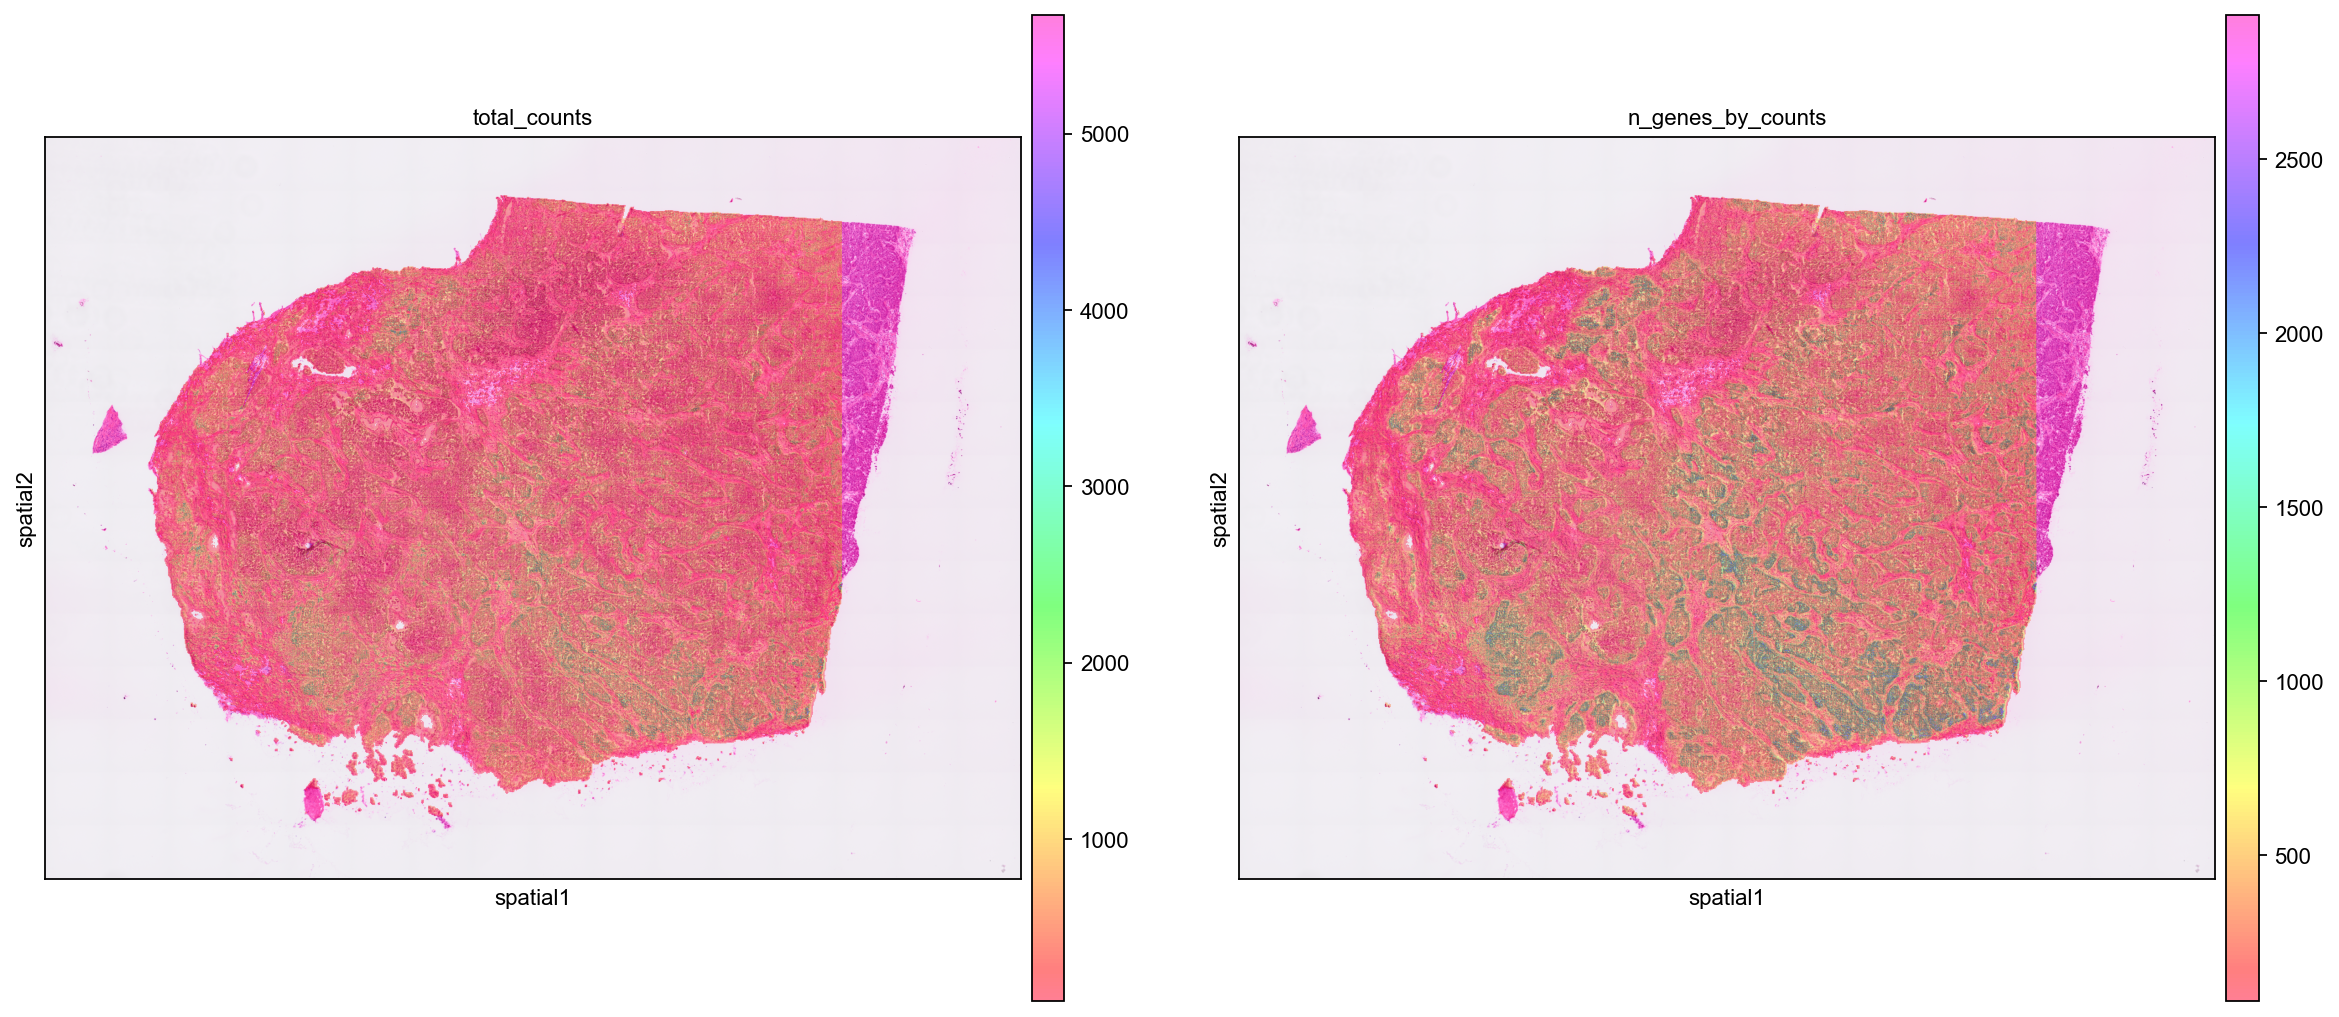

In [13]:
# Visualization in spatial coordinates 
plt.rcParams["figure.figsize"] = (8, 8)
sq.pl.spatial_scatter(bdata, img_res_key="hires", color=["total_counts", "n_genes_by_counts"], 
                      cmap="gist_rainbow", alpha=0.5)

In [14]:
# Normalize data with built-in normalize_total method from Scanpy
sc.pp.normalize_total(bdata,target_sum=1e4)
sc.pp.log1p(bdata)

# Make a copy of filtered raw data
bdata.raw = bdata.copy()

# Detect highly-variable genes, flavor='seurat_v3' mimics Seurat’s FindVariableFeatures()
sc.pp.highly_variable_genes(bdata, flavor="seurat_v3", n_top_genes=5000)

In [15]:
# Standard clustering 
sc.pp.scale(bdata, max_value=10)
sc.pp.pca(bdata, use_highly_variable=True)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)

auto.py (21): IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


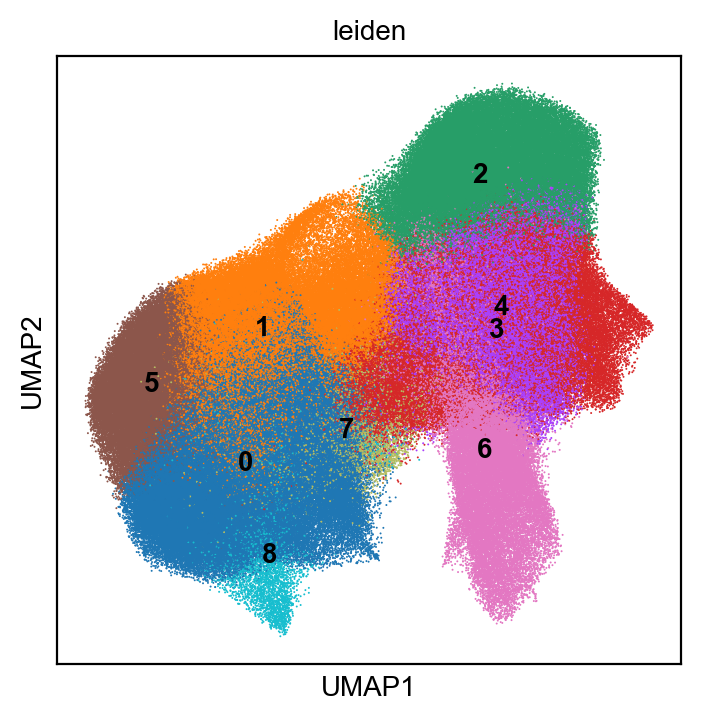

In [16]:
# Find CLusters with Leiden algorith
sc.set_figure_params(dpi=100,fontsize=10,)
sc.tl.leiden(bdata,resolution=0.65,key_added='leiden')

# Plot UMAP
sc.pl.umap(bdata,color=['leiden'],size=2,wspace=0.25, legend_loc='on data')

In [17]:
# Store the data
bdata.write('fresh_breast_8um_filtered5.h5ad')

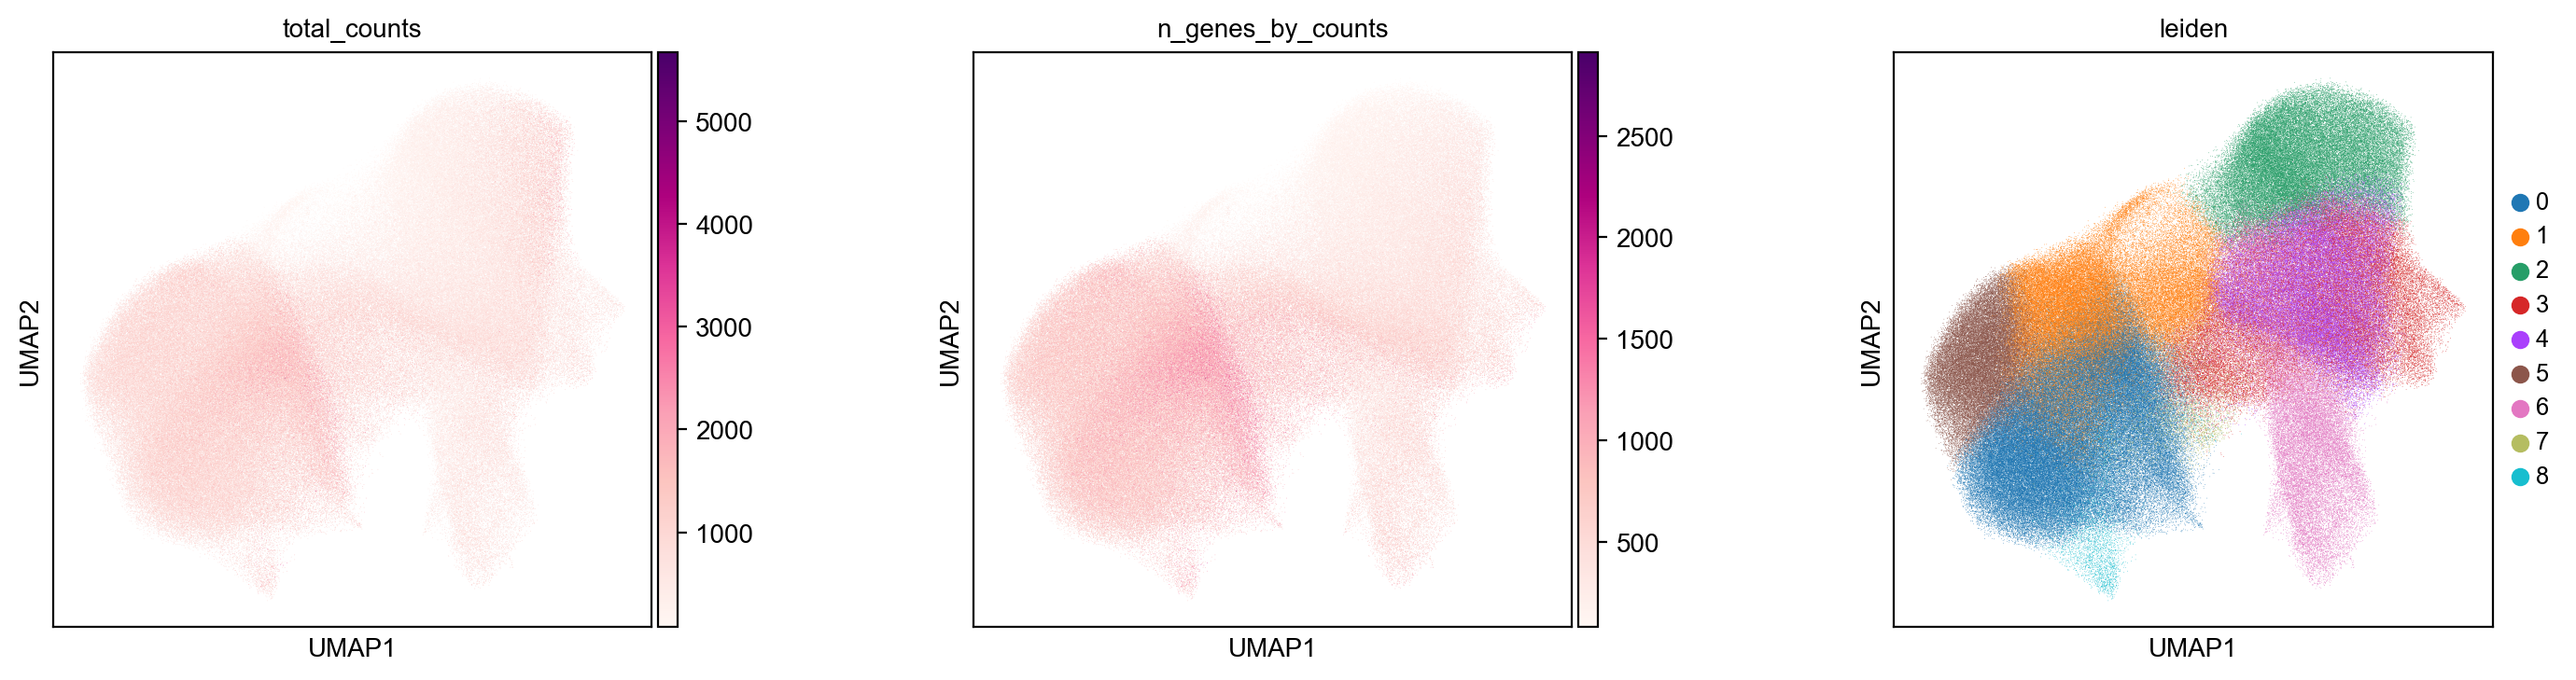

In [18]:
# Plot some covariates to check if there is any particular structure in the UMAP associated 
# with total counts and detected genes
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(bdata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)

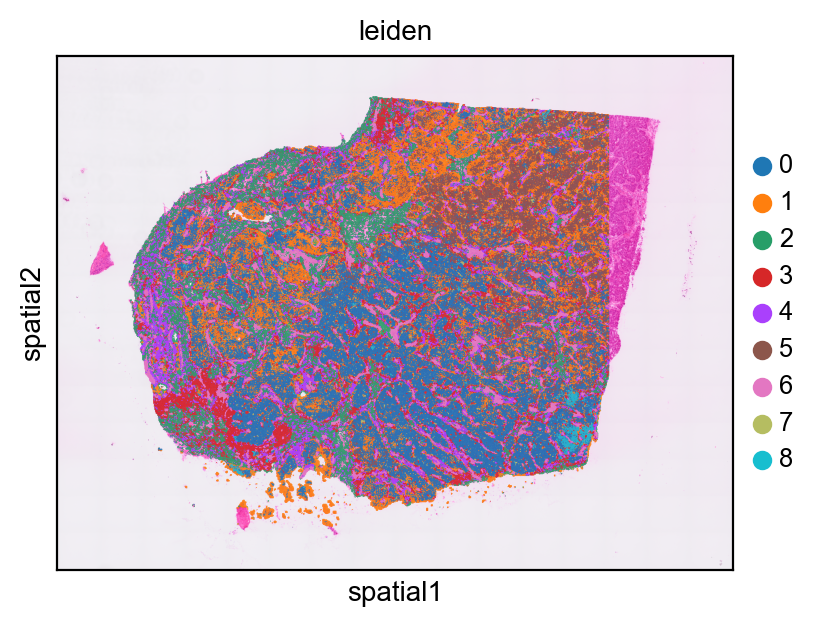

In [19]:
# Visualization clustered samples in spatial dimensions
sq.pl.spatial_scatter(bdata, img_res_key="hires", color="leiden", size=1.5)

In [20]:
# Memory
print("The memory utilized in this chunk was:", process.memory_info().rss / 1e6, "MB") # In MB 

The memory utilized in this chunk was: 27914.043392 MB


In [21]:
bdata.obs["leiden"].value_counts()

leiden
0    124734
1     82907
2     59626
3     54162
4     51303
5     45109
6     34533
7      6400
8      4555
Name: count, dtype: int64

In [22]:
# Obtain cluster-specific differentially expressed genes
# Compute marker genes and plot a heatmap with expression levels of its top 10 marker genes across clusters
sc.tl.rank_genes_groups(bdata, "leiden", method="wilcoxon")

# Create a variable with the cluster names 
groups_all = bdata.uns["rank_genes_groups"]["names"].dtype.names

In [23]:
# Extract the markers for all the clusters
markers = sc.get.rank_genes_groups_df(bdata, group=None)
markers

group   names      scores  logfoldchanges  pvals  pvals_adj
0          0    CD24  304.457062        2.581045    0.0        0.0
1          0   MUCL1  300.009583        2.844987    0.0        0.0
2          0    TSKU  284.031860        2.997357    0.0        0.0
3          0    APOD  265.275879        2.770922    0.0        0.0
4          0  MT-ND2  261.977509        2.006167    0.0        0.0
...      ...     ...         ...             ...    ...        ...
147370     8  COL3A1  -38.070698       -2.734135    0.0        0.0
147371     8  COL1A2  -38.191437       -2.866685    0.0        0.0
147372     8  COL1A1  -42.980598       -2.657823    0.0        0.0
147373     8   IGHG1  -46.461735       -2.832702    0.0        0.0
147374     8    IGKC  -51.861065       -3.053873    0.0        0.0

[147375 rows x 6 columns]

In [24]:
# Filter the markers ["logfoldchanges"] >=1 & ["pvals_adj"] <=0.05
filt_markers = markers[(markers["logfoldchanges"] >=1) &(markers["pvals_adj"] <=0.05)] 
filt_markers

group   names      scores  logfoldchanges     pvals  pvals_adj
0          0    CD24  304.457062        2.581045  0.000000   0.000000
1          0   MUCL1  300.009583        2.844987  0.000000   0.000000
2          0    TSKU  284.031860        2.997357  0.000000   0.000000
3          0    APOD  265.275879        2.770922  0.000000   0.000000
4          0  MT-ND2  261.977509        2.006167  0.000000   0.000000
...      ...     ...         ...             ...       ...        ...
133971     8   RHPN2    2.767084        1.053841  0.005656   0.028639
134049     8   TTLL7    2.705271        1.013797  0.006825   0.033682
134100     8  C2CD4B    2.662446        1.498690  0.007757   0.037649
134110     8   AADAT    2.656019        1.175700  0.007907   0.038261
134164     8   RRP12    2.599291        1.062931  0.009342   0.044416

[5815 rows x 6 columns]

In [25]:
# Group by cluster, get the top 15 markers for each cluster
top15 = (filt_markers.groupby("group", group_keys=False).apply(lambda x: x.head(15)).reset_index(drop=True))

2354735784.py (2): DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [26]:
# For loop to extract the top markers from each cluster 
clusters = top15["group"].unique()
# Empty dictionary to save the results 
for_cluster = {} 

# Loop for each cluster 
for c in clusters: 
    subset = top15.names[top15["group"] == c]
    for_cluster[c] = subset # Save the subset per cluster

    print(f"Cluster {c}:") 
    print(subset)

Cluster 0:
0        CD24
1       MUCL1
2        TSKU
3        APOD
4      MT-ND2
5         LTF
6       ERBB2
7      MT-ND4
8        PNMT
9     MT-ATP6
10       KRT7
11       MUC1
12       MLPH
13      AZGP1
14     MT-CO2
Name: names, dtype: object
Cluster 1:
15       CD24
16     MT-CO3
17        CLU
18     MT-CO2
19    MT-ATP6
20     MT-ND4
21      ERBB2
22    MT-ND4L
23     MT-CYB
24     MT-ND2
25       FASN
26       KRT7
27     MT-ND3
28      DHRS2
29     CRYBG1
Name: names, dtype: object
Cluster 2:
30     IGHG1
31      IGKC
32     IGHG3
33     IGHA1
34     IGLC1
35    COL1A1
36    TXNDC5
37      IGHD
38      MZB1
39     SPARC
40    COL1A2
41    COL3A1
42    TENT5C
43     DERL3
44      PIM2
Name: names, dtype: object
Cluster 3:
45      APOE
46      CD74
47      CTSB
48      PSAP
49       LYZ
50    TMSB4X
51      CTSZ
52      C1QC
53      CTSD
54       FTL
55       VIM
56      CD68
57      C1QB
58      C1QA
59    LAPTM5
Name: names, dtype: object
Cluster 4:
60    COL1A1
61    COL1A2
6

In [27]:
# Manual Annotation with PanglaoDB and CellMarker performed with 15 top genes for each cluster

In [28]:
# Change names clusters to cell types identified in annotation
new_cluster_names = {
    '0' : '0.Célula progenitora epitelial/Célula B reguladora B10',
    '1' : '1.Célula progenitora epitelial/Fibroblasto asoc. a cáncer', 
    '2' : '2.Miofibroblasto/Célula plasmática',
    '3' : '3.Panmacrófago/Fibroblasto asoc. a cáncer',
    '4' : '4.Miofibroblasto/Pericito',
    '5' : '5.Célula epitelial luminal/Célula madre cancerosa',
    '6' : '6.Miofibroblasto/Pericito',
    '7' : '7.Célula progenitora epitelial/Fibroblasto asoc. a cáncer',
    '8' : '8.Célula progenitora epitelial/Célula B reguladora B10'
}

# Replace names in bdata 
bdata.obs['leiden_celltypes'] = bdata.obs['leiden'].map(new_cluster_names).astype('category')

In [29]:
# Perform GO for each cluster using top 15 markers
gp = GProfiler(return_dataframe=True)

# Create empty dictionary to save the results per cluster 
go_results = {} 

# Loop for each cluster for the previously defined dictionary for_cluster
for cluster, genes in for_cluster.items(): 
    genes = genes.tolist()
    # Biological process (BP)
    res = gp.profile(organism="hsapiens", query=genes, sources=["GO:BP"])
    go_results[cluster] = res
    
    print(f"The GO results for the cluster {cluster}:")
    print(res[["name", "p_value", "source"]].head(10))

The GO results for the cluster 0:
                                                name   p_value source
0                          response to oxygen levels  0.002657  GO:BP
1                          oxidative phosphorylation  0.002784  GO:BP
2                     proton transmembrane transport  0.007927  GO:BP
3                                aerobic respiration  0.009520  GO:BP
4  proton motive force-driven mitochondrial ATP s...  0.014444  GO:BP
5                               cellular respiration  0.020592  GO:BP
6           proton motive force-driven ATP synthesis  0.022840  GO:BP
7  negative regulation of transforming growth fac...  0.024303  GO:BP
8                      establishment of localization  0.027026  GO:BP
9                                 response to stress  0.033752  GO:BP
The GO results for the cluster 1:
                                                name       p_value source
0                           electron transport chain  5.089930e-12  GO:BP
1             

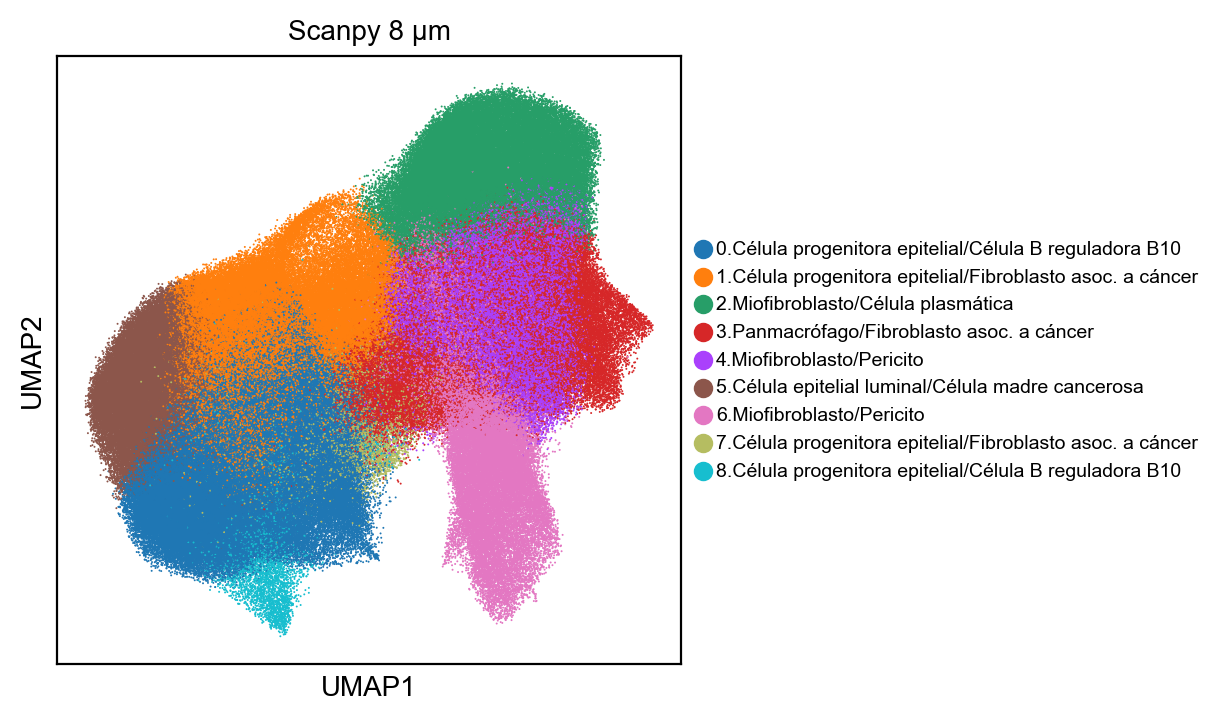

In [30]:
# Plot UMAP with cell types 
sc.pl.umap(bdata,color=['leiden_celltypes'],size=2,wspace=0.25, legend_fontsize=7, 
           title = "Scanpy 8 µm")

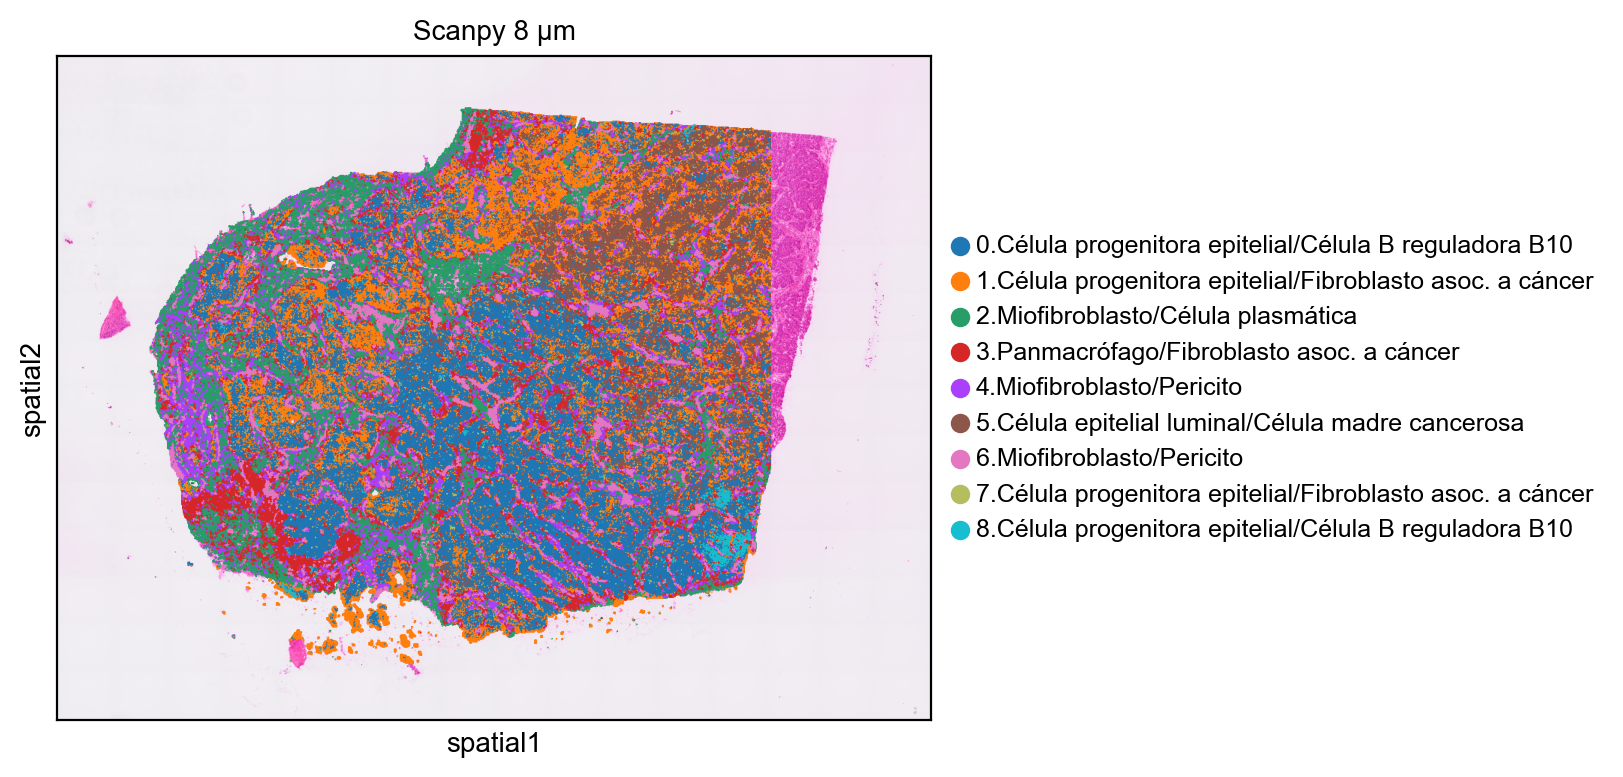

In [31]:
# Visualization clustered samples in spatial dimensions with cell types
sq.pl.spatial_scatter(bdata, img_res_key="hires", color="leiden_celltypes", size=2,
                      figsize=(8,6),legend_fontsize=9, title = "Scanpy 8 µm")

In [32]:
# Obtain a list of top 10 gene names per cluster to plot heatmap
top_genes = filt_markers.groupby('group')['names'].apply(lambda x: x[:10]).explode().unique().tolist()

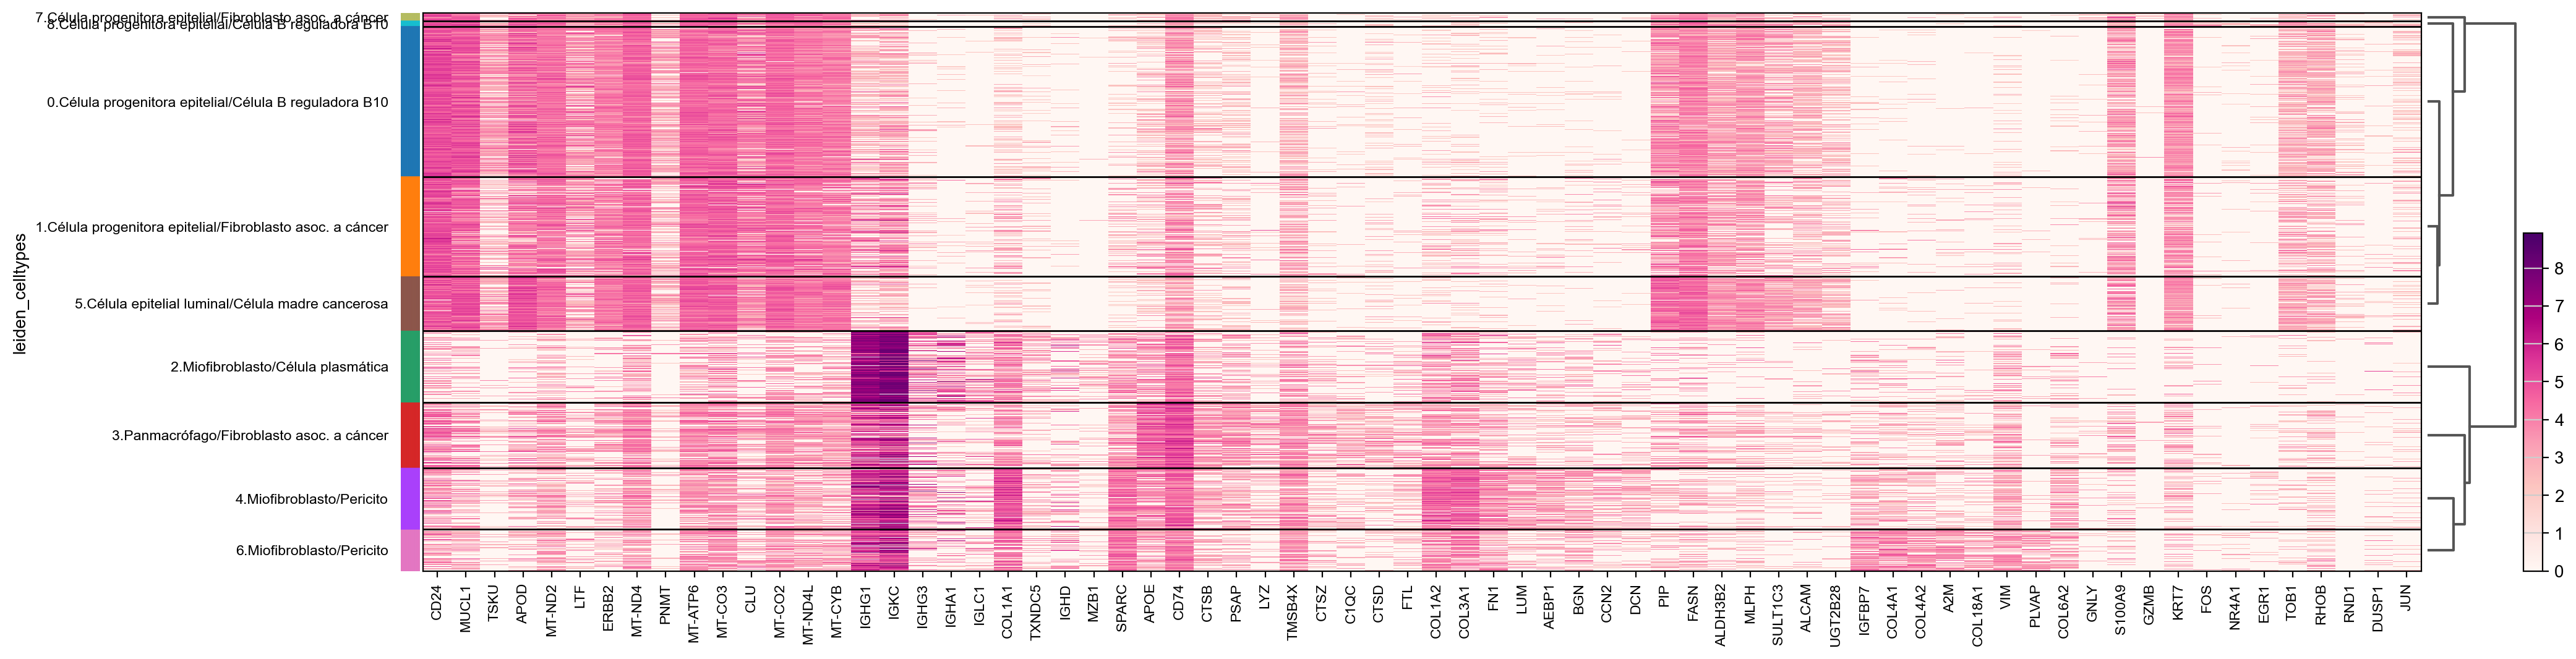

In [33]:
# Plot heatmap with top 10 genes for each cluster
sc.pl.rank_genes_groups_heatmap(bdata, groups=groups_all, var_names=top_genes, 
                                groupby="leiden_celltypes", show_gene_labels=True,
                                save = "heatmap_Scanpy8.png")

In [34]:
# End time 
end_time = time.time() 
elapsed_time = end_time - start_time 

# Print results
print(f"Total time: {elapsed_time: .2f} seconds") 

Total time:  2989.82 seconds


In [35]:
# Calculate memory information
memory = psutil.virtual_memory()
# Convert Bytes to MB (Bytes -> KB -> MB)
available = round(memory.available/1024.0/1024.0,1)
total = round(memory.total/1024.0/1024.0,1)
mem_info = str(available) + 'MB free / ' + str(total) + 'MB total ( ' + str(memory.percent) + '% used )'
# Print results
print(mem_info)

3003.8MB free / 32674.9MB total ( 90.8% used )
